In [1]:
!pip install emoji
!pip install stop-words
!pip install transformers datasets imblearn seaborn

  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=c98592915296c7732fa70cd545ddce43ed566df05663d07195fd2b110ae2328e
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,EarlyStoppingCallback,AutoModel
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
import emoji
import string
from nltk.corpus import stopwords
from stop_words import get_stop_words
import nltk
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import random
from imblearn.over_sampling import RandomOverSampler
from transformers import EarlyStoppingCallback

nltk.download('punkt')
nltk.download('stopwords')
tqdm.pandas()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('/kaggle/input/data12/final_full_data_main.csv')
df

,text,label
0,মেয়েরা উদ্দেশ্য অনুসারে বোবা বোবা আচরণ সুন্দর,1.0
1,গুরুত্বপূর্ণ প্রশ্ন জিজ্ঞাসা সত্যিই পছন্দ করি।...,1.0
2,বাহ ... পাচ্ছি সত্যিই দোষী দোষী সাব্যস্তনোটপ্রেসড,1.0
3,"হাহ, মজার বিষয়।আনোয়েড গ্রুআপ",1.0
4,থান্ডার 830 জেগে উঠলে ভালবাসুন,1.0
...,...,...
8210,बॉलिवुड़ फिल्में देखो। चाहते मुझे रेडिट मैंसेज...,0.0
8211,इनमें बहन भेजा वो पूछेगी कहीं मेरी तबियत खराब,0.0
8212,"“नही, अब बात आ गई क्या मुझे थोड़े रूपये मिल है?""",0.0
8213,**अन्तरजाल स्रोतों** वाचन हिन्दी साहित्य हर दौ...,0.0


In [4]:
label_counts = df['label'].value_counts()
print("Count of tweets with label 1.0 (sarcastic):", label_counts[1.0])
print("Count of tweets with label 0.0 (non-sarcastic):", label_counts[0.0])

Count of tweets with label 1.0 (sarcastic): 1909
Count of tweets with label 0.0 (non-sarcastic): 6306


In [5]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [6]:
X_trainf, X_test, y_trainf, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=seed, stratify=df['label']
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainf, y_trainf, test_size=0.1, random_state=seed, stratify=y_trainf
)

X_train = X_train.astype(str)
X_test = X_test.astype(str)
X_valid = X_valid.astype(str)

y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)
y_valid = pd.Series(y_valid).reset_index(drop=True)

In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [8]:
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=150):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

In [9]:
ros = RandomOverSampler(random_state=seed)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.to_frame(), y_train)

label_counts12 = y_train_resampled.value_counts()
print("Count of tweets with label 1.0 (sarcastic):", label_counts12[1.0])
print("Count of tweets with label 0.0 (non-sarcastic):", label_counts12[0.0])

X_train_resampled = X_train_resampled['text']

Count of tweets with label 1.0 (sarcastic): 4540
Count of tweets with label 0.0 (non-sarcastic): 4540


In [10]:
train_dataset = SarcasmDataset(
    texts=X_train_resampled.tolist(),
    labels=y_train_resampled.tolist(),
    tokenizer=tokenizer,
)

valid_dataset = SarcasmDataset(
    texts=X_valid.tolist(),
    labels=y_valid.tolist(),
    tokenizer=tokenizer,
)

test_dataset = SarcasmDataset(
    texts=X_test.tolist(),
    labels=y_test.tolist(),
    tokenizer=tokenizer,
)

In [11]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-7,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    seed=seed
)

# Define a metric function for trainer
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"Train accuracy": accuracy_score(p.label_ids, preds)}

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    compute_metrics=compute_metrics
)

train_results = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Train accuracy
1,0.679800,0.679401,0.635258
2,0.648000,0.644063,0.741641
3,0.604600,0.603054,0.752280
4,0.544200,0.557718,0.759878
5,0.532800,0.514317,0.767477
6,0.479200,0.493925,0.770517
7,0.533600,0.468528,0.781155
8,0.484000,0.455153,0.791793
9,0.469400,0.455034,0.796353
10,0.407600,0.448734,0.800912


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Epoch 1: Training Loss = 0.6480, Validation Loss = 0.6794
Epoch 2: Training Loss = 0.6046, Validation Loss = 0.6441
Epoch 3: Training Loss = 0.5442, Validation Loss = 0.6031
Epoch 4: Training Loss = 0.5529, Validation Loss = 0.5577
Epoch 5: Training Loss = 0.4792, Validation Loss = 0.5143
Epoch 6: Training Loss = 0.5336, Validation Loss = 0.4939
Epoch 7: Training Loss = 0.4840, Validation Loss = 0.4685
Epoch 8: Training Loss = 0.4694, Validation Loss = 0.4552
Epoch 9: Training Loss = 0.4542, Validation Loss = 0.4550
Epoch 10: Training Loss = 0.3929, Validation Loss = 0.4487
Epoch 11: Training Loss = 0.3880, Validation Loss = 0.4379
Epoch 12: Training Loss = 0.3412, Validation Loss = 0.4336
Epoch 13: Training Loss = 0.4060, Validation Loss = 0.4267
Epoch 14: Training Loss = 0.3722, Validation Loss = 0.4270
Epoch 15: Training Loss = 0.4166, Validation Loss = 0.4232
Epoch 16: Training Loss = 0.3946, Validation Loss = 0.4196
Epoch 17: Training Loss = 0.4295, Validation Loss = 0.4198
Epoch 

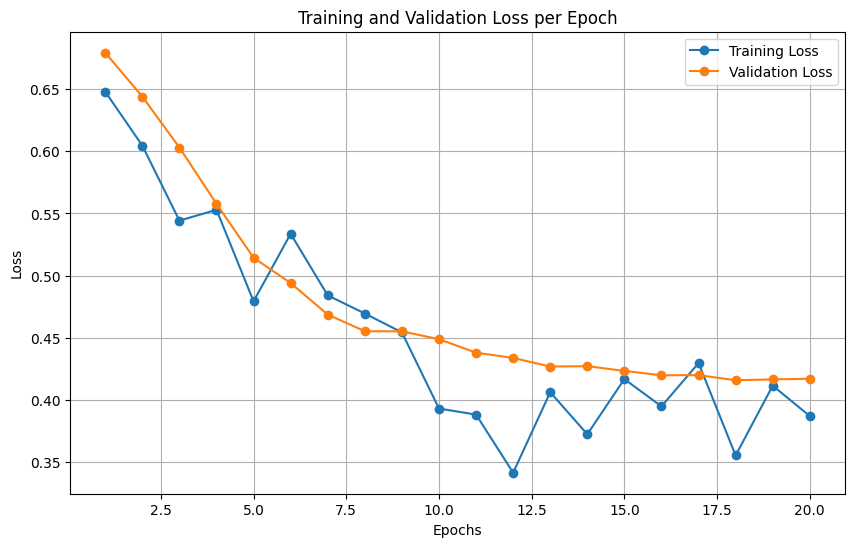

In [14]:
log_history = trainer.state.log_history

epoch_train_losses = {}
epoch_eval_losses = {}

for entry in log_history:
    if 'epoch' in entry:
        epoch = int(entry['epoch'])
        # Record training loss if present (last one encountered per epoch is used)
        if 'loss' in entry:
            epoch_train_losses[epoch] = entry['loss']
        # Record evaluation loss if present
        if 'eval_loss' in entry:
            epoch_eval_losses[epoch] = entry['eval_loss']

# Only consider epochs that have both training and eval losses
common_epochs = sorted(set(epoch_train_losses.keys()) & set(epoch_eval_losses.keys()))
final_train_losses = [epoch_train_losses[e] for e in common_epochs]
final_eval_losses = [epoch_eval_losses[e] for e in common_epochs]

for epoch, (train_loss, eval_loss) in enumerate(zip(final_train_losses, final_eval_losses), start=1):
    print(f"Epoch {epoch}: Training Loss = {train_loss:.4f}, Validation Loss = {eval_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(common_epochs, final_train_losses, label="Training Loss", marker="o")
plt.plot(common_epochs, final_eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid()
plt.show()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test Accuracy: 0.8101


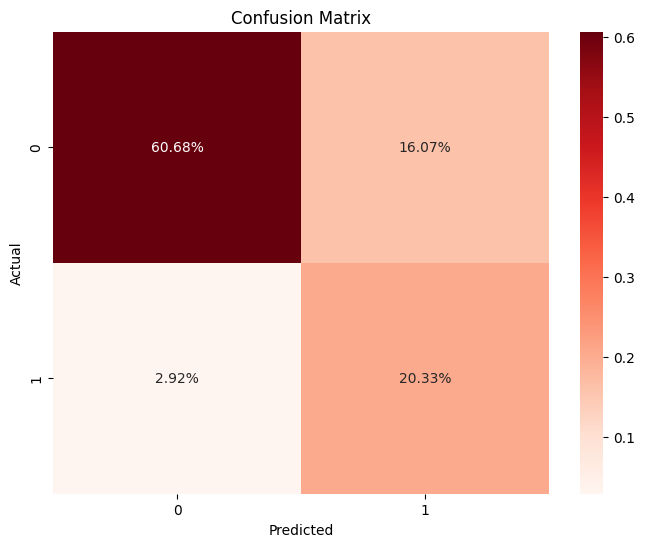

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.79      0.86      1261
         1.0       0.56      0.87      0.68       382

    accuracy                           0.81      1643
   macro avg       0.76      0.83      0.77      1643
weighted avg       0.86      0.81      0.82      1643



In [15]:
test_predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(test_predictions.predictions, axis=1)

# Accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, predicted_labels))

In [16]:
# import pandas as pd
# import numpy as np
# import torch
# import random
# import matplotlib.pyplot as plt
# import seaborn as sns

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# from imblearn.over_sampling import RandomOverSampler

# from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
# from transformers import EarlyStoppingCallback
# from torch.utils.data import Dataset

# # Set random seeds for reproducibility
# seed = 42
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)

# # ------------------------------------------------------
# # Step 1: Split dataset
# # ------------------------------------------------------
# X_trainf, X_test, y_trainf, y_test = train_test_split(
#     df['text'], df['label'], test_size=0.2, random_state=seed, stratify=df['label']
# )

# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_trainf, y_trainf, test_size=0.1, random_state=seed, stratify=y_trainf
# )

# X_train = X_train.astype(str)
# X_test = X_test.astype(str)
# X_valid = X_valid.astype(str)

# y_train = pd.Series(y_train).reset_index(drop=True)
# y_test = pd.Series(y_test).reset_index(drop=True)
# y_valid = pd.Series(y_valid).reset_index(drop=True)

# # ------------------------------------------------------
# # Step 2: Initialize tokenizer and device
# # ------------------------------------------------------
# tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
# #tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # ------------------------------------------------------
# # Step 3: Define Dataset class
# # ------------------------------------------------------
# class SarcasmDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_length=150):
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         encoding = self.tokenizer(
#             self.texts[idx],
#             padding="max_length",
#             truncation=True,
#             max_length=self.max_length,
#             return_tensors="pt",
#         )
#         return {
#             "input_ids": encoding["input_ids"].squeeze(),
#             "attention_mask": encoding["attention_mask"].squeeze(),
#             "labels": torch.tensor(self.labels[idx], dtype=torch.long),
#         }

# # ------------------------------------------------------
# # Step 4: Balance the training dataset using Oversampling
# # ------------------------------------------------------
# ros = RandomOverSampler(random_state=seed)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train.to_frame(), y_train)

# label_counts12 = y_train_resampled.value_counts()
# print("Count of tweets with label 1.0 (sarcastic):", label_counts12[1.0])
# print("Count of tweets with label 0.0 (non-sarcastic):", label_counts12[0.0])

# X_train_resampled = X_train_resampled['text']

# # ------------------------------------------------------
# # Step 5: Create tokenized datasets
# # ------------------------------------------------------
# train_dataset = SarcasmDataset(
#     texts=X_train_resampled.tolist(),
#     labels=y_train_resampled.tolist(),
#     tokenizer=tokenizer,
# )

# valid_dataset = SarcasmDataset(
#     texts=X_valid.tolist(),
#     labels=y_valid.tolist(),
#     tokenizer=tokenizer,
# )

# test_dataset = SarcasmDataset(
#     texts=X_test.tolist(),
#     labels=y_test.tolist(),
#     tokenizer=tokenizer,
# )

# # ------------------------------------------------------
# # Step 6: Initialize model for classification
# # ------------------------------------------------------
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
# #model = AutoModelForSequenceClassification.from_pretrained("ai4bharat/indic-bert", num_labels=2).to(device)

# # ------------------------------------------------------
# # Step 7: Set training arguments
# # ------------------------------------------------------
# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=1e-6,
#     logging_dir="./logs",
#     logging_steps=10,
#     save_total_limit=2,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=20,
#     weight_decay=0.1,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_loss",
#     seed=seed
# )

# # Define a metric function for trainer
# def compute_metrics(p):
#     preds = np.argmax(p.predictions, axis=1)
#     return {"Train accuracy": accuracy_score(p.label_ids, preds)}

# # ------------------------------------------------------
# # Step 8: Initialize Trainer
# # ------------------------------------------------------
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=valid_dataset,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
#     compute_metrics=compute_metrics
# )

# # ------------------------------------------------------
# # Step 9: Train the model
# # ------------------------------------------------------
# train_results = trainer.train()

# # ------------------------------------------------------
# # Step 10: Extract training and validation losses by epoch
# # ------------------------------------------------------
# log_history = trainer.state.log_history

# epoch_train_losses = {}
# epoch_eval_losses = {}

# for entry in log_history:
#     if 'epoch' in entry:
#         epoch = int(entry['epoch'])
#         # Record training loss if present (last one encountered per epoch is used)
#         if 'loss' in entry:
#             epoch_train_losses[epoch] = entry['loss']
#         # Record evaluation loss if present
#         if 'eval_loss' in entry:
#             epoch_eval_losses[epoch] = entry['eval_loss']

# # Only consider epochs that have both training and eval losses
# common_epochs = sorted(set(epoch_train_losses.keys()) & set(epoch_eval_losses.keys()))
# final_train_losses = [epoch_train_losses[e] for e in common_epochs]
# final_eval_losses = [epoch_eval_losses[e] for e in common_epochs]

# for epoch, (train_loss, eval_loss) in enumerate(zip(final_train_losses, final_eval_losses), start=1):
#     print(f"Epoch {epoch}: Training Loss = {train_loss:.4f}, Validation Loss = {eval_loss:.4f}")

# plt.figure(figsize=(10, 6))
# plt.plot(common_epochs, final_train_losses, label="Training Loss", marker="o")
# plt.plot(common_epochs, final_eval_losses, label="Validation Loss", marker="o")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss per Epoch")
# plt.legend()
# plt.grid()
# plt.show()

# # ------------------------------------------------------
# # Step 11: Final evaluation on the test set
# # ------------------------------------------------------
# test_predictions = trainer.predict(test_dataset)
# predicted_labels = np.argmax(test_predictions.predictions, axis=1)

# # Accuracy
# accuracy = accuracy_score(y_test, predicted_labels)
# print(f"Test Accuracy: {accuracy:.4f}")

# # Confusion Matrix
# cf_matrix = confusion_matrix(y_test, predicted_labels)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Reds')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # Classification Report
# print("Classification Report:\n", classification_report(y_test, predicted_labels))